In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sys
import geopandas as gpd
import geoplot as gplt
import geoplot.crs as gcrs

%matplotlib inline

S Tse 
2/18/18

Following the hypothesis that Census Response Rates may be correlated with social capital ([Martin and Newman, 2014](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.1019.2188&rep=rep1&type=pdf); [Hotchkiss, 2017](https://www2.census.gov/ces/wp/2017/CES-WP-17-39.pdf)) especially at smaller tract geography, this notebook explores tract-level census response rates from the 2016 US Census Bureau Planning Database for the PDX Metro Area (Multnomah, Washington, and Clackamas Counties).

Documentation for the database can be found [here](https://www.census.gov/research/data/planning_database/2016/docs/2016-Tract-PDB-Documentation-V8.pdf) and the data (60MB ZIP/CSV) can be downloaded [here](https://www.census.gov/research/data/planning_database/2016/docs/pdb2016trv8_us.zip).

In [2]:
# read in tract data
df = pd.read_csv("pdb2016trv8_us.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74024 entries, 0 to 74023
Columns: 562 entries, GIDTR to pct_BILQ_Mailout_count_CEN_2010
dtypes: float64(544), int64(4), object(14)
memory usage: 317.4+ MB


In [4]:
# the df is very wide. Let's just look at the first 5 columns
df[df.columns[:6]].head()

,GIDTR,State,State_name,County,County_name,Tract
0,1001020100,1,Alabama,1,Autauga County,20100
1,1001020200,1,Alabama,1,Autauga County,20200
2,1001020300,1,Alabama,1,Autauga County,20300
3,1001020400,1,Alabama,1,Autauga County,20400
4,1001020500,1,Alabama,1,Autauga County,20500


In [5]:
# peek at some rows for just Multnomah County
df[df['County_name']=='Multnomah County'].head()

,GIDTR,State,State_name,County,County_name,Tract,Flag,Num_BGs_in_Tract,LAND_AREA,AIAN_LAND,...,pct_TEA_MailOutMailBack_CEN_2010,pct_TEA_Update_Leave_CEN_2010,pct_Census_Mail_Returns_CEN_2010,pct_Vacants_CEN_2010,pct_Deletes_CEN_2010,pct_Census_UAA_CEN_2010,pct_Mailback_Count_CEN_2010,pct_FRST_FRMS_CEN_2010,pct_RPLCMNT_FRMS_CEN_2010,pct_BILQ_Mailout_count_CEN_2010
55015,41051000100,41,Oregon,51,Multnomah County,100,NaN,7.0,1.360,0.0,...,100.0,NaN,76.10,4.06,0.0,5.20,90.75,76.06,0.03,NaN
55016,41051000200,41,Oregon,51,Multnomah County,200,NaN,4.0,0.906,0.0,...,100.0,NaN,76.87,1.75,0.0,4.80,93.45,76.84,0.03,NaN
55017,41051000301,41,Oregon,51,Multnomah County,301,NaN,4.0,0.877,0.0,...,100.0,NaN,68.54,3.37,0.0,6.01,90.62,68.54,0.00,NaN
55018,41051000302,41,Oregon,51,Multnomah County,302,NaN,6.0,1.233,0.0,...,100.0,NaN,84.39,1.49,0.0,2.79,95.72,84.39,0.00,NaN
55019,41051000401,41,Oregon,51,Multnomah County,401,NaN,4.0,0.524,0.0,...,100.0,NaN,80.41,2.10,0.0,3.15,94.76,80.41,0.00,NaN


In [6]:
df['GIDTR'].dtype
# I'll need to convert to string later

dtype('int64')

In [7]:
# Full FIPS county code (last 3 are county specific)
# 41051 Multnomah
# 41067 Washington
# 41005 Clackamas
pdx_counties = ['Multnomah County', 'Clackamas County', 'Washington County']
pdx_tracts = df[(df['County_name'].isin(pdx_counties)) & (df['State_name']=='Oregon')]

In [8]:
pdx_tracts[pdx_tracts.columns[:6]].head()

,GIDTR,State,State_name,County,County_name,Tract
54554,41005020100,41,Oregon,5,Clackamas County,20100
54555,41005020200,41,Oregon,5,Clackamas County,20200
54556,41005020302,41,Oregon,5,Clackamas County,20302
54557,41005020303,41,Oregon,5,Clackamas County,20303
54558,41005020304,41,Oregon,5,Clackamas County,20304


In [9]:
pdx_tracts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 355 entries, 54554 to 55345
Columns: 562 entries, GIDTR to pct_BILQ_Mailout_count_CEN_2010
dtypes: float64(544), int64(4), object(14)
memory usage: 1.5+ MB


After filtering for state and county name, we are down to 562 rows (census tracts) which seems reasonable. 


### Univariate Analysis

Let's explore some variables: 

* Mail_Return_Rate_CEN_2010 (2010 Census Mail Return Rate, Unit Level: Addresses) The number of mail returns received out of the total number of valid occupied housing units (HUs) in the Mailout/Mailback universe which excludes deleted, vacant, or units identified as undeliverable as addressed. Therefore, variable 294 can be less than variable 287 because of these exclusions. A small number of tracts contain only HUs that do not meet the requirement to be considered a valid, occupied HU. This variable will have a missing value for these tracts. 

* Low_Response_Score Prediction of low census mail return rate, Unit Level: Addresses) A score predicting that a block group will produce a low mail return rate.  This score is negatively associated with Mail_Return_Rate_CEN_2010. 
 




In [10]:
# return rates for pdx area
pdx_tracts['Mail_Return_Rate_CEN_2010'].describe()

count    354.000000
mean      79.581073
std        5.297245
min       63.500000
25%       75.800000
50%       80.250000
75%       83.175000
max       94.400000
Name: Mail_Return_Rate_CEN_2010, dtype: float64

In [11]:
# return rates nationally
df['Mail_Return_Rate_CEN_2010'].describe()

count    72789.000000
mean        78.692768
std          7.876387
min          0.000000
25%         74.300000
50%         79.600000
75%         84.300000
max        100.000000
Name: Mail_Return_Rate_CEN_2010, dtype: float64

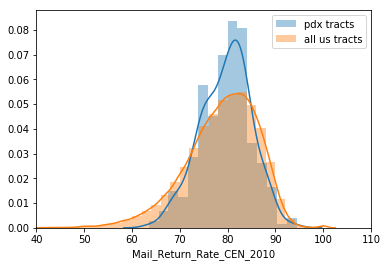

In [12]:
sns.distplot(pdx_tracts['Mail_Return_Rate_CEN_2010'].dropna(), label='pdx tracts')
sns.distplot(df['Mail_Return_Rate_CEN_2010'].dropna(),label='all us tracts')
plt.xlim(40,110)
plt.legend()

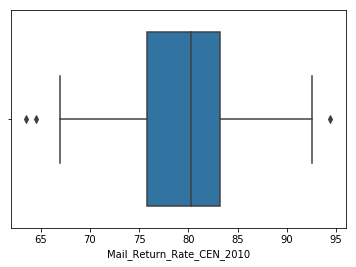

In [13]:
sns.boxplot(pdx_tracts['Mail_Return_Rate_CEN_2010'])

Without doing any statitical analysis, it appears that the central tendency of pdx area return rates is similar to the national distribution, although national has a higher standard deviation. 

In [14]:
# predicted Low Response Score (LRS) for pdx area
pdx_tracts['Low_Response_Score'].describe()

count    354.000000
mean      20.474011
std        3.966039
min       10.200000
25%       17.700000
50%       20.350000
75%       23.100000
max       32.200000
Name: Low_Response_Score, dtype: float64

In [15]:
# # predicted Low Response Score (LRS) for pdx area
df['Low_Response_Score'].describe()

count    71876.000000
mean        21.132569
std          5.808846
min          0.000000
25%         16.800000
50%         20.300000
75%         25.100000
max         57.800000
Name: Low_Response_Score, dtype: float64

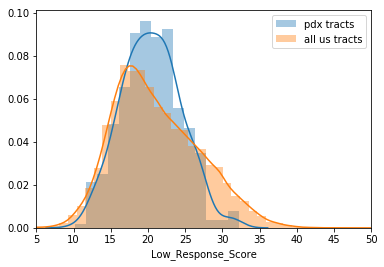

In [16]:
sns.distplot(pdx_tracts['Low_Response_Score'].dropna(), label='pdx tracts')
sns.distplot(df['Low_Response_Score'].dropna(),label='all us tracts')
plt.xlim(5,50)
plt.legend()

The Census Bureau's LRS is calcualted from a predictive model. More info here: https://www.census.gov/content/dam/Census/newsroom/press-kits/2017/aapor/2017-aapor-larsen.pdf

We can see the model predicts PDX area to have a slightly better distribtion based on central tendency and variation. The model predicts the national distrubiton of LRS by tract to be more right skewed.


### Spatial Analysis

Downloaded 2016 Census Tract [shapefiles](https://www.census.gov/geo/maps-data/data/cbf/cbf_tracts.html) for OR.


In [17]:
# read OR shapesfiles into geodatframe
tract_shapes = gpd.read_file("cb_2016_41_tract_500k.shp")

In [18]:
tract_shapes.head()

,STATEFP,COUNTYFP,TRACTCE,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
0,41,001,950100,1400000US41001950100,41001950100,9501,CT,2871065097,14489031,"POLYGON ((-118.51944 44.705886, -118.518181 44..."
1,41,001,950600,1400000US41001950600,41001950600,9506,CT,2796734200,30628721,"POLYGON ((-117.777504 44.992161, -117.747664 4..."
2,41,003,000900,1400000US41003000900,41003000900,9,CT,9590455,0,"POLYGON ((-123.338108 44.591266, -123.335775 4..."
3,41,003,010300,1400000US41003010300,41003010300,103,CT,627552469,864231,"POLYGON ((-123.816709 44.344622, -123.776615 4..."
4,41,005,020800,1400000US41005020800,41005020800,208,CT,3982134,309866,"POLYGON ((-122.660979 45.457819, -122.656972 4..."


In [19]:
tract_shapes.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 828 entries, 0 to 827
Data columns (total 10 columns):
STATEFP     828 non-null object
COUNTYFP    828 non-null object
TRACTCE     828 non-null object
AFFGEOID    828 non-null object
GEOID       828 non-null object
NAME        828 non-null object
LSAD        828 non-null object
ALAND       828 non-null int64
AWATER      828 non-null int64
geometry    828 non-null object
dtypes: int64(2), object(8)
memory usage: 64.8+ KB


In [20]:
# Full FIPS county code (last 3 are county specific)
# 41051 Multnomah
# 41067 Washington
# 41005 Clackamas
pdx_fips = ['051', '067', '005']
# subset by pdx area counties
pdx_tract_shapes = tract_shapes[tract_shapes['COUNTYFP'].isin(pdx_fips)]

In [21]:
pdx_tract_shapes.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 355 entries, 4 to 827
Data columns (total 10 columns):
STATEFP     355 non-null object
COUNTYFP    355 non-null object
TRACTCE     355 non-null object
AFFGEOID    355 non-null object
GEOID       355 non-null object
NAME        355 non-null object
LSAD        355 non-null object
ALAND       355 non-null int64
AWATER      355 non-null int64
geometry    355 non-null object
dtypes: int64(2), object(8)
memory usage: 30.5+ KB


In [22]:
# as seen above, pdx_tracts['GIDTR'] column dtype is int so these must be converted to string for before merging.
pdx_tracts['GIDTR'] = pdx_tracts['GIDTR'].astype('str')


C:\Users\Scott\Anaconda2\envs\disaster_env\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [23]:
# merge response rate and predicted response rate onto pdx_tract_shapes
pdx_tract_shapes = pdx_tract_shapes.merge(
    pdx_tracts[['GIDTR','Mail_Return_Rate_CEN_2010',
                        'Low_Response_Score','County_name']],
    how = 'inner', 
    left_on = 'GEOID',
    right_on = 'GIDTR').sort_values('GEOID')

In [24]:
pdx_tract_shapes.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 355 entries, 328 to 350
Data columns (total 14 columns):
STATEFP                      355 non-null object
COUNTYFP                     355 non-null object
TRACTCE                      355 non-null object
AFFGEOID                     355 non-null object
GEOID                        355 non-null object
NAME                         355 non-null object
LSAD                         355 non-null object
ALAND                        355 non-null int64
AWATER                       355 non-null int64
geometry                     355 non-null object
GIDTR                        355 non-null object
Mail_Return_Rate_CEN_2010    354 non-null float64
Low_Response_Score           354 non-null float64
County_name                  355 non-null object
dtypes: float64(2), int64(2), object(10)
memory usage: 41.6+ KB


In [25]:
pdx_tract_shapes

,STATEFP,COUNTYFP,TRACTCE,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry,GIDTR,Mail_Return_Rate_CEN_2010,Low_Response_Score,County_name
328,41,005,020100,1400000US41005020100,41005020100,201,CT,4553343,217059,"POLYGON ((-122.707838 45.424479, -122.703961 4...",41005020100,84.1,16.3,Clackamas County
95,41,005,020200,1400000US41005020200,41005020200,202,CT,5657392,1118789,"POLYGON ((-122.723574 45.40485, -122.723075 45...",41005020200,83.8,16.2,Clackamas County
63,41,005,020302,1400000US41005020302,41005020302,203.02,CT,3458164,0,"POLYGON ((-122.744057 45.418585, -122.744006 4...",41005020302,79.1,19.5,Clackamas County
35,41,005,020303,1400000US41005020303,41005020303,203.03,CT,2317806,0,"POLYGON ((-122.725541 45.433167, -122.721663 4...",41005020303,80.9,18.5,Clackamas County
96,41,005,020304,1400000US41005020304,41005020304,203.04,CT,2433046,1260,"POLYGON ((-122.743991 45.426023, -122.743721 4...",41005020304,83.0,17.9,Clackamas County
278,41,005,020401,1400000US41005020401,41005020401,204.01,CT,4020439,42715,"POLYGON ((-122.743939 45.393033, -122.743933 4...",41005020401,85.8,15.2,Clackamas County
97,41,005,020403,1400000US41005020403,41005020403,204.03,CT,4051825,22931,"POLYGON ((-122.720253 45.384324, -122.720055 4...",41005020403,88.1,10.2,Clackamas County
279,41,005,020404,1400000US41005020404,41005020404,204.04,CT,3043109,694035,"POLYGON ((-122.714457 45.403762, -122.713606 4...",41005020404,88.5,12.7,Clackamas County
280,41,005,020501,1400000US41005020501,41005020501,205.01,CT,13078680,0,"POLYGON ((-122.697715 45.37967099999999, -122....",41005020501,81.0,18.1,Clackamas County
98,41,005,020503,1400000US41005020503,41005020503,205.03,CT,2352122,18518,"POLYGON ((-122.683194 45.400931, -122.67904 45...",41005020503,85.4,15.1,Clackamas County


C:\Users\Scott\Anaconda2\envs\disaster_env\lib\site-packages\pysal\esda\mapclassify.py:267: RuntimeWarning: invalid value encountered in greater
  binIds += (x > l) * (x <= r) * k
C:\Users\Scott\Anaconda2\envs\disaster_env\lib\site-packages\pysal\esda\mapclassify.py:267: RuntimeWarning: invalid value encountered in less_equal
  binIds += (x > l) * (x <= r) * k
C:\Users\Scott\Anaconda2\envs\disaster_env\lib\site-packages\numpy\lib\function_base.py:4033: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


Text(0.5,1,'Mail_Return_Rate_CEN_2010 by Census Tract')

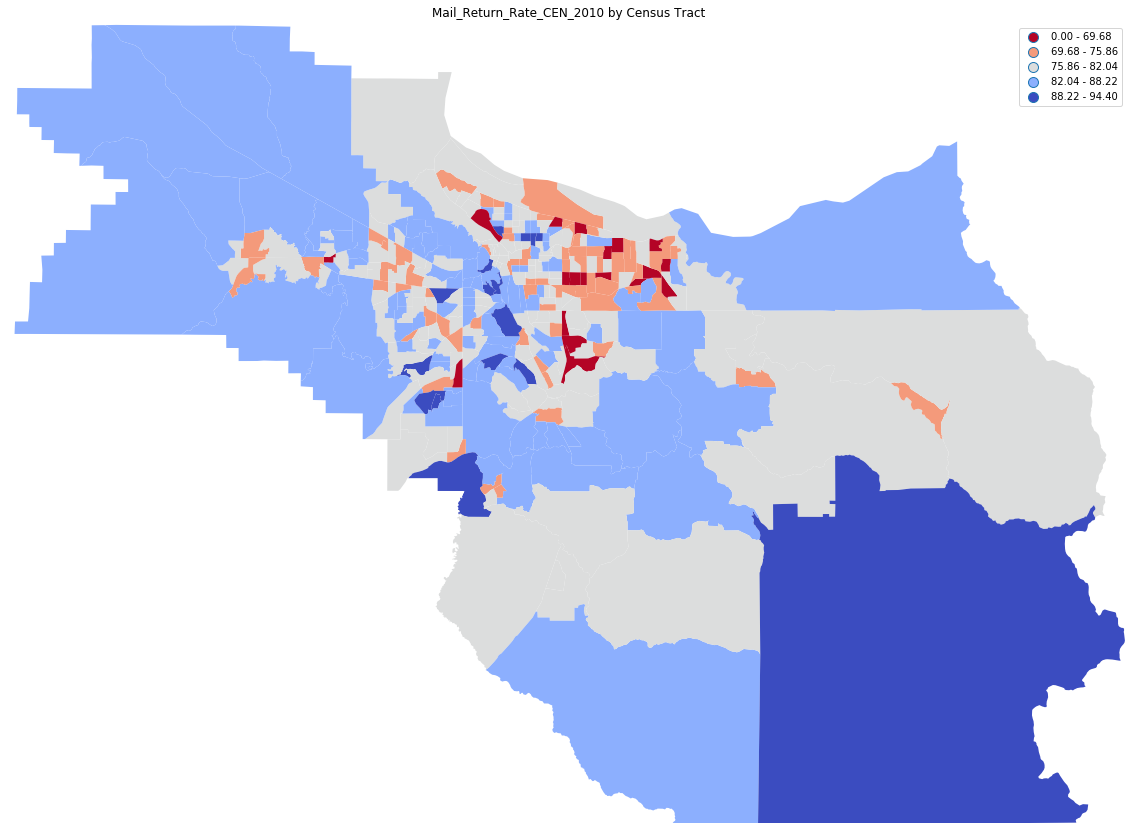

In [26]:
# make choropleth of mail return rates by census tract
gplt.choropleth(pdx_tract_shapes,
                hue=pdx_tract_shapes['Mail_Return_Rate_CEN_2010'],  # Display data, passed as a Series
                projection=gcrs.AlbersEqualArea(),
                cmap='coolwarm_r',
                linewidth=0.5,
                #k=9,
                legend=True,
                scheme='equal_interval',
                figsize=(20, 20))

plt.title("Mail_Return_Rate_CEN_2010 by Census Tract")

C:\Users\Scott\Anaconda2\envs\disaster_env\lib\site-packages\pysal\esda\mapclassify.py:267: RuntimeWarning: invalid value encountered in greater
  binIds += (x > l) * (x <= r) * k
C:\Users\Scott\Anaconda2\envs\disaster_env\lib\site-packages\pysal\esda\mapclassify.py:267: RuntimeWarning: invalid value encountered in less_equal
  binIds += (x > l) * (x <= r) * k
C:\Users\Scott\Anaconda2\envs\disaster_env\lib\site-packages\numpy\lib\function_base.py:4033: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


Text(0.5,1,'Low_Response_Score by Census Tract')

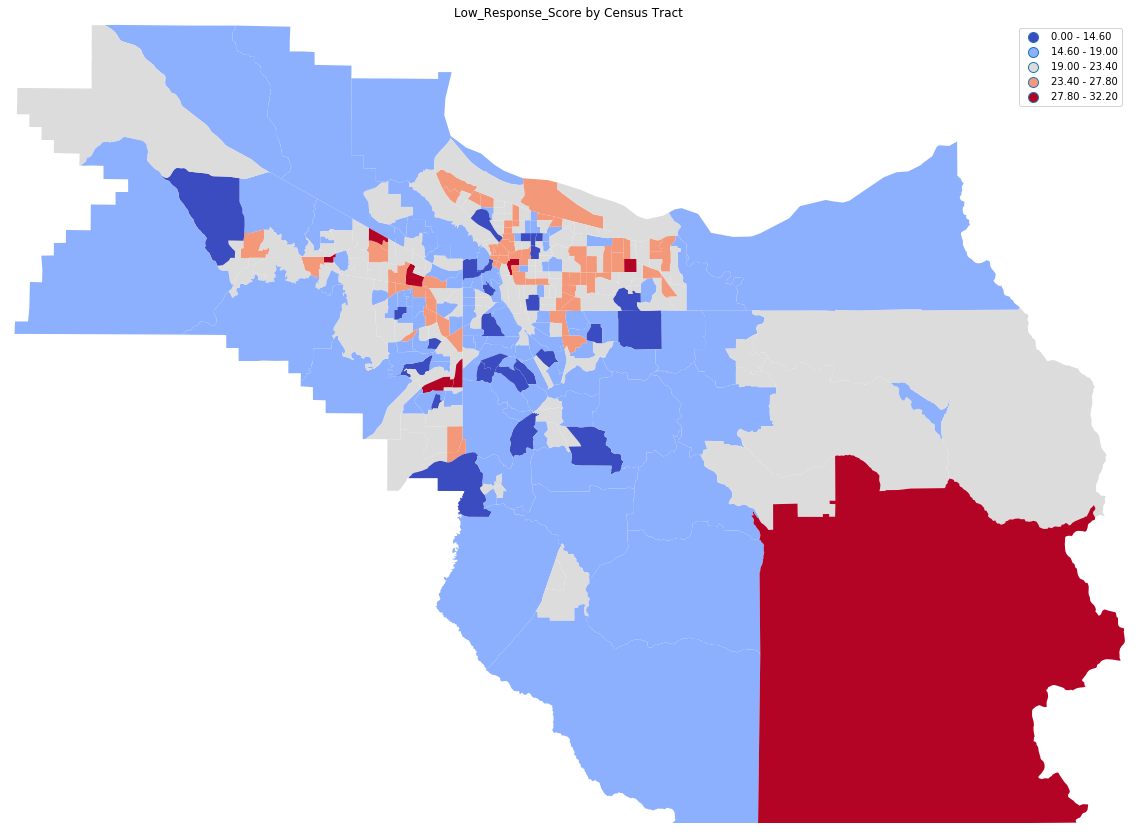

In [27]:
# make choropleth of low response scrore by census tract
gplt.choropleth(pdx_tract_shapes,
                hue=pdx_tract_shapes['Low_Response_Score'],  # Display data, passed as a Series
                projection=gcrs.AlbersEqualArea(),
                cmap='coolwarm',
                linewidth=0.5,
                #k=9,
                legend=True,
                scheme='equal_interval',
                figsize=(20, 20))

plt.title("Low_Response_Score by Census Tract")

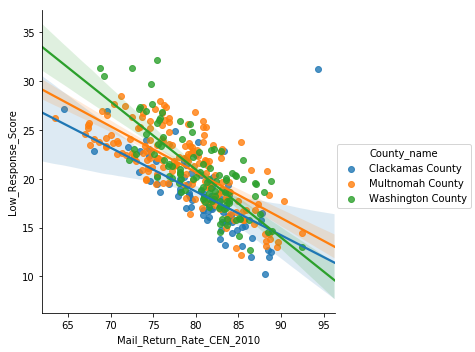

In [28]:
sns.lmplot(data=pdx_tract_shapes, x='Mail_Return_Rate_CEN_2010', y='Low_Response_Score', hue='County_name')

Notes:
    * as expected, there is negative correlation between 2010 Mail Return Rate and 2016 Low Response Rate Score
    * weird that the county in far SW Clackamas has a high response rate but also has high LRS. What feature is overcoming response rate in that tract?
    * need to understand details of LRS model better
    * can current LRS predicted values act as solid indicator of current social capital?
   